# SIFT (using opencv)

## Binary Image matching
Through the development of your own image stitching utility, you've learned the utility of being able to match keypoints in images, and how the process is done (find a good keypoint, extract a local descriptor, match these descriptors against each other).  However, the keypoint detection and matching that we implemented ourselves was sub-optimal in the sense that it did not preserve important invariances like rotation and scale.  For our endeavours into 3D scene reconstruction, we will instead switch to the de facto gold standard of keypoint matching methods, known as Scale Invariant Feature Transform, or SIFT.  

In essence, SIFT works just like Harris Corners, patch descriptors, and normalized SSE, with a few extra tweaks to make it better.  Instead of implementing SIFT ourselves, we will use the excellent implementation from OpenCV.  However, there is a small issue: SIFT is a non-free algorithm (it is free for academic use, but restricted from unlicensed commercial use).  As such it is not bundled with the standard OpenCV library.  Instead, it must be aquired separately.  However, this is made easy using pip (for those of you with linux or mac).  A simple

pip install --user opencv-contrib-python==3.4.2.17

will suffice to get both opencv and the non-free libraries associated with it. 

Once opencv is installed, it's straightforward to use with numpy.  The generation of SIFT keypoints and detectors is as follows:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

I_1 = plt.imread('I_1.jpg')
I_2 = plt.imread('I_2.jpg')

sift = cv2.xfeatures2d.SIFT_create(contrastThreshold=0.04,edgeThreshold=10,sigma=1.6)
kp1,des1 = sift.detectAndCompute(I_1,None)
kp2,des2 = sift.detectAndCompute(I_2,None)

It's as simple as that.  Now, with the keypoints and descriptors generated, we can match them using a simple $n^2$ matching utility (note that there are faster matchers out there that provide approximate matches).

In [2]:
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(des1,des2,k=2)

As before, we'll want to do some simple quality control, using the ratio test.  The matches object above is a list of lists, containing the best and second best matches according to the SSE error metric.  

In [3]:
print(matches[0])

[<DMatch 0x7f943469a170>, <DMatch 0x7f93f8155df0>]


The error for each match can be found using match.distance

In [4]:
print(matches[0][0].distance)

195.95663452148438


**Code the ratio test.  Create a list of 'good' matches that pass the test**.

In [5]:
good_matches = []
r = 0.7
for m, n in matches:
    # Compute the ratio between best match m, and second best match n here
    if m.distance < r * n.distance:
        good_matches.append([m])


When this is complete, opencv offers you a mechanism for producing side-by-side keypoint match plots just like the ones you generated for Harris corners.  The syntax for this is straightforward:

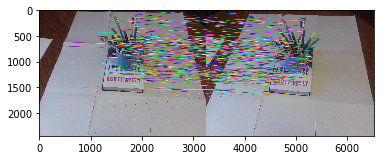

In [6]:
img = cv2.drawMatchesKnn(I_1,kp1,I_2,kp2,good_matches,None,flags=2) 
plt.imshow(img)

**Generate such a composite image using pictures that you take today in class (2 of the many), and using the good matches that you computed above**.

In [7]:
def get_best_sift_matches(I_1, I_2, r=0.7):

    sift = cv2.xfeatures2d.SIFT_create(contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)
    kp1, des1 = sift.detectAndCompute(I_1, None)
    kp2, des2 = sift.detectAndCompute(I_2, None)

    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        # Compute the ratio between best match m, and second best match n here
        if m.distance < r * n.distance:
            good_matches.append(m)

    u1 = []
    u2 = []

    for g in good_matches:
        u1.append(kp1[g.queryIdx].pt)
        u2.append(kp2[g.trainIdx].pt)

    u1 = np.array(u1)
    u2 = np.array(u2)

#     u1 = np.c_[u1, np.ones(u1.shape[0])]
#     u2 = np.c_[u2, np.ones(u2.shape[0])]

    return u1, u2

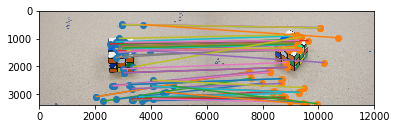

In [20]:
img1 = plt.imread("./pictures/cube/DSC03896.JPG")
img2 = plt.imread("./pictures/cube/DSC03897.JPG")

h, w, d = img1.shape

c1, c2 = get_best_sift_matches(img1, img2, r=0.5)

# beware the datatype, it can change the way pyplot maps colors. uint8 ensures range 0-255 colors
img = np.zeros((h, 2*w, 3)).astype(np.uint8)
img[:, :w, :] = img1
img[:, w:, :] = img2
plt.scatter(c1[::1, 0], c1[::1, 1])
plt.scatter(c2[::1, 0]+w, c2[::1, 1])
[plt.plot([c1[0], c2[0]+w], [c1[1], c2[1]]) for c1, c2 in zip(c1[::1], c2[::1])]

plt.imshow(img)
plt.show()